# Data Analysis

- [Data Viewer](#Data-Viewer)
- [Custom Dataset & DataLoader](#Custom-Dataset-&-DataLoader)

### DirectoryStructure

```
.
├── data
│   ├── eastpac
│   │   ├── ...
│   │   └── eastpac_goes16_2017_308_2140.nc
│   └── natlantic
│       ├── ...
│       └── natlantic_goes16_2017_308_1810.nc
├── notebooks
│   └── stock-analysis.ipynb
└── src
    └── read_region.py
```

In [1]:
import sys
sys.path.append('../src')

import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision import transforms

import read_region as rr
import goesdataset as gd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

# Data Viewer

In [2]:
def normalize(X):
    
    Xmin = np.min(X, axis=tuple([0, 2, 3])).reshape(1, X.shape[1], 1, 1)
    Xmax = np.max(X, axis=tuple([0, 2, 3])).reshape(1, X.shape[1], 1, 1)
 
    return (X - Xmin)/(Xmax - Xmin)

def square_data(X):
    nnew  = min(X.shape[2], X.shape[3])
    return X[:, :, 0:nnew, 0:nnew]

def imshow16(X, figsize=(8, 4)):
    fig, axs = plt.subplots(4, 4, figsize=figsize)
    [ax.set_axis_off() for ax in axs.ravel()]

    c = 0
    for i in range(4):
        for j in range(4):
            im = axs[i, j].imshow(X[:,c:c+1,...].reshape(X.shape[-2], X.shape[-1]), 
                                  interpolation='nearest', cmap='viridis')
            c += 1

    fig.tight_layout()
    fig.colorbar(im, ax=axs.ravel().tolist())

    plt.show()
    
def showfile(filename, square=False):
    if not os.path.exists(filename):
        print('ERROR: path to file does not exist!')
    else:
        cData = rr.read_region(filename, channels=True, geo=False, retrievals=False)

        X = np.array(cData['c00'])
        X = np.expand_dims(np.moveaxis(X, 2, 0), axis=0)
        
        figsize = (8, 4)
        
        if square or 'east' in filename:
            X = square_data(X)
            figsize = (6, 5)
        
        X = normalize(X)
        print(X.shape)
        
        imshow16(X, figsize=figsize)

In [3]:
volume = '../data'

## Northern Atlantic Ocean

In [4]:
showfile(volume + '/natlantic/natlantic_goes16_2017_308_1410.nc')

ERROR: path to file does not exist!


## Eastern Pacific Ocean

(1, 16, 20, 20)


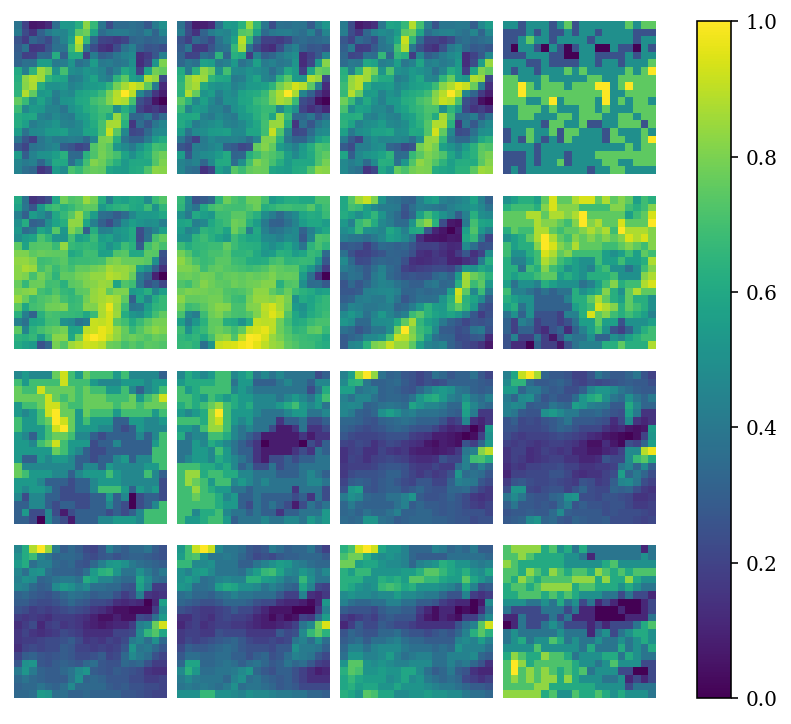

In [5]:
showfile(volume + '/subset-copy/eastpac2_goes16_2017_331_1900_240.nc')

# Custom Dataset & DataLoader

In [6]:
eastpac = gd.GOESDataset(root_dir='../data/subset-copy/',
                         transform=transforms.Compose([
                                gd.Square(), gd.Normalize(), gd.ToTensor()
                         ]))
eastpac

Dataset GOESDataset
Number of datapoints: 256
Root location: ../data/subset-copy/
Compose(
    Square()
    Normalize()
    ToTensor()
)

In [7]:
train_loader = torch.utils.data.DataLoader(eastpac, batch_size=3)

In [9]:
def save_1(X, filename, title):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)

    im = ax.imshow(X.reshape(X.shape[-2], X.shape[-1]),
                          interpolation='nearest', cmap='viridis')

    ax.set_title(title)
    fig.colorbar(im)
    plt.show()

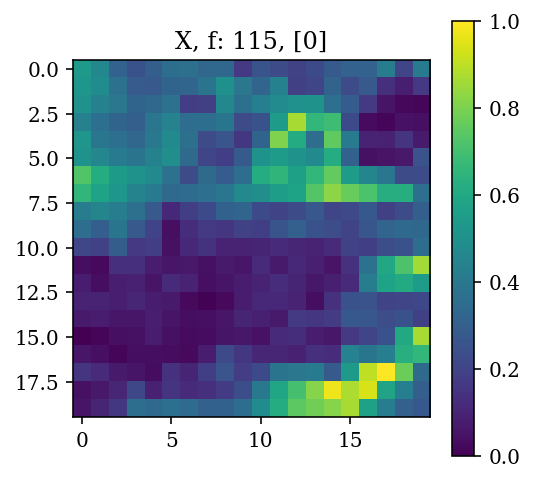

In [10]:
n = 115
ch = 0
o_filename = 'somewhere'
X = train_loader.dataset[n][0][ch:ch+1,...]
save_1(X, o_filename, f'X, f: {n}, [{ch}]')

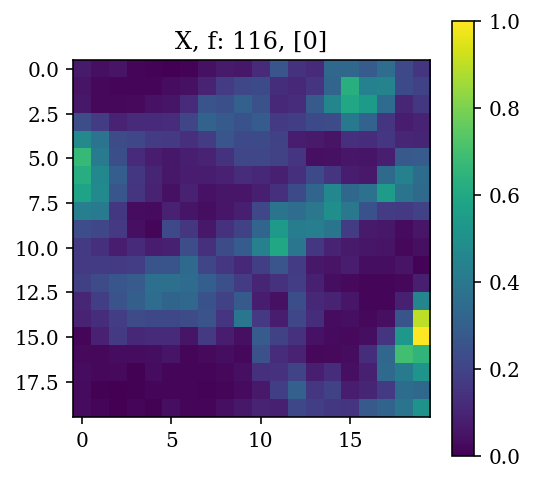

In [11]:
n = 116
ch = 0
o_filename = f'../media/{str(n)}_original'
X = train_loader.dataset[n][0][ch:ch+1,...]
save_1(X, o_filename, f'X, f: {n}, [{ch}]')

## HDFS

In [24]:
filename = volume + '/subset-copy/eastpac2_goes16_2017_331_1900_156.nc'
cData = rr.read_region(filename, channels=True, geo=False, retrievals=True)
X, T = cData['c00'], np.array(cData['ctype'])
X.shape, T.shape

((20, 20, 16), (20, 20))

In [25]:
X = np.expand_dims(np.moveaxis(X, 2, 0), axis=0)
X = square_data(X)
X = normalize(X)[0, ...]

In [26]:
nnew = min(T.shape[0], T.shape[1])
T = T[0:nnew, 0:nnew]
T.shape

(20, 20)

In [27]:
i = 0
T = T[i:i+20,i:i+20]
T

array([[0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
counts = np.bincount(T.flatten())
label = np.argmax(counts)
label

0

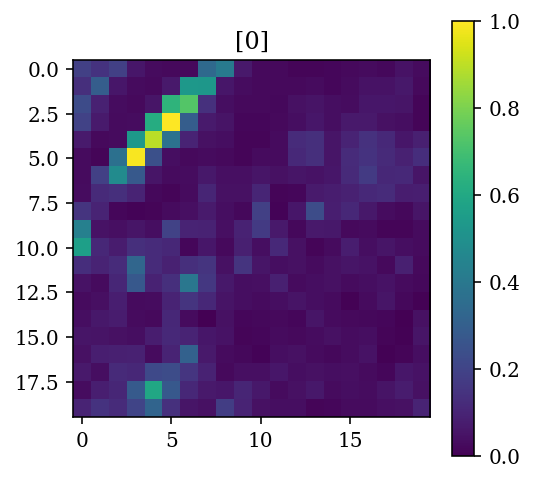

In [30]:
ch = 0
X = X[ch:ch+1,i:i+20,i:i+20]
save_1(X, '', f'[{ch}]')

$20x20 => 1x2$

In [31]:
a = np.array( [[-0.4, 0.25], 
               [-0.3, 0.2], 
               [-0.2, 0.21]] )

b = np.array( [[0.5, 0.4], 
               [0.4, 0.2], 
               [0.45, 0.21]] )

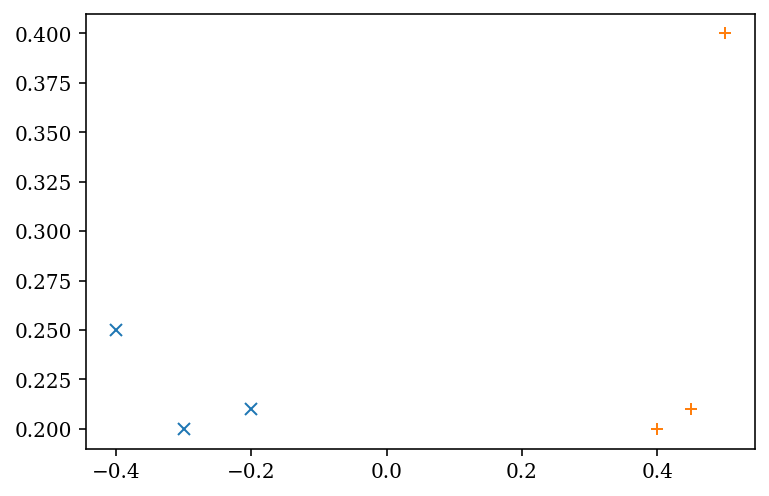

In [32]:
plt.plot(a[:,:1], a[:,1:], 'x')
plt.plot(b[:,:1], b[:,1:], '+');

# PCA/tSNE on RAW Data

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pylab as pl

In [36]:
X, T = [], []
for i in range(len(eastpac)):
    X.append(eastpac[i][0][0, ...].flatten().numpy())
    T.append(eastpac[i][1].item())

In [37]:
components = PCA(n_components=2).fit_transform(X)
embeded = TSNE(n_components=2).fit_transform(X)

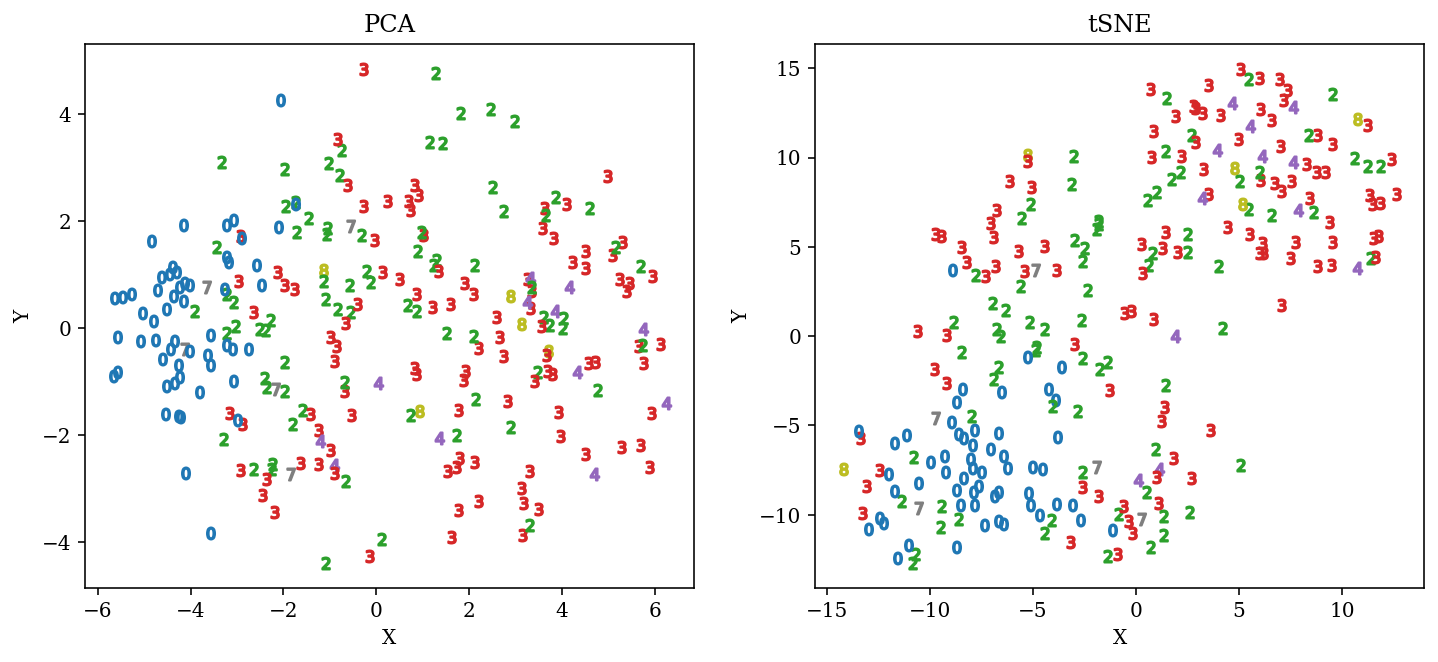

In [38]:
COLORS = pl.cm.tab10(np.linspace(0, 1, 10))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)

for i in range(len(X)):
    ax.plot(components[i, 0], components[i, 1], 
            marker='${}$'.format(T[i]), c=COLORS[T[i]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

for i in range(len(X)):
    ax.plot(embeded[i, 0], embeded[i, 1], 
            marker='${}$'.format(T[i]), c=COLORS[T[i]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('tSNE')

plt.show()